In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import random


In [18]:

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ハイパーパラメータの設定
num_epochs = 100
batch_size = 128
learning_rate = 0.001
momentum = 0.9

# CIFAR-10データセットの準備
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Using device: cuda


In [19]:

# Self-Attention層の定義
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Attention weight
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, height, width = x.size()
        proj_query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)  # B x (H*W) x C'
        proj_key = self.key(x).view(batch_size, -1, height * width)  # B x C' x (H*W)
        energy = torch.bmm(proj_query, proj_key)  # batch matrix multiplication: B x (H*W) x (H*W)
        attention = self.softmax(energy)  # B x (H*W) x (H*W)
        proj_value = self.value(x).view(batch_size, -1, height * width)  # B x C x (H*W)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1)).view(batch_size, C, height, width)  # B x C x H x W

        return self.gamma * out + x, attention

# CNNモデルの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.attention = SelfAttention(128)  # Self-Attention層を追加
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x, attention_map = self.attention(x)  # Self-Attention層を通過
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x, attention_map  # アテンションマップを返すように変更

    def get_features(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x, _ = self.attention(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu4(self.fc1(x))
        return x


In [20]:

# モデルのインスタンス化
net = Net().to(device)

# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

# 学習の記録用リスト
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 学習ループ
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs, _ = net(inputs)  # アテンションマップはここでは使用しない
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # テストフェーズ
    net.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs, _ = net(images)  # アテンションマップはここでは使用しない
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Epoch [1/100], Train Loss: 2.2928, Train Accuracy: 13.14%
Epoch [1/100], Test Loss: 2.2752, Test Accuracy: 15.84%
Epoch [2/100], Train Loss: 2.2025, Train Accuracy: 20.48%
Epoch [2/100], Test Loss: 2.1127, Test Accuracy: 22.94%
Epoch [3/100], Train Loss: 2.0379, Train Accuracy: 26.31%
Epoch [3/100], Test Loss: 1.9559, Test Accuracy: 29.89%
Epoch [4/100], Train Loss: 1.9210, Train Accuracy: 30.70%
Epoch [4/100], Test Loss: 1.8659, Test Accuracy: 32.82%
Epoch [5/100], Train Loss: 1.8271, Train Accuracy: 33.98%
Epoch [5/100], Test Loss: 1.7608, Test Accuracy: 35.89%
Epoch [6/100], Train Loss: 1.7243, Train Accuracy: 37.46%
Epoch [6/100], Test Loss: 1.6656, Test Accuracy: 39.11%
Epoch [7/100], Train Loss: 1.6472, Train Accuracy: 40.10%
Epoch [7/100], Test Loss: 1.6014, Test Accuracy: 41.11%
Epoch [8/100], Train Loss: 1.5920, Train Accuracy: 41.79%
Epoch [8/100], Test Loss: 1.5621, Test Accuracy: 43.04%
Epoch [9/100], Train Loss: 1.5490, Train Accuracy: 43.19%
Epoch [9/100], Test Loss: 1.51

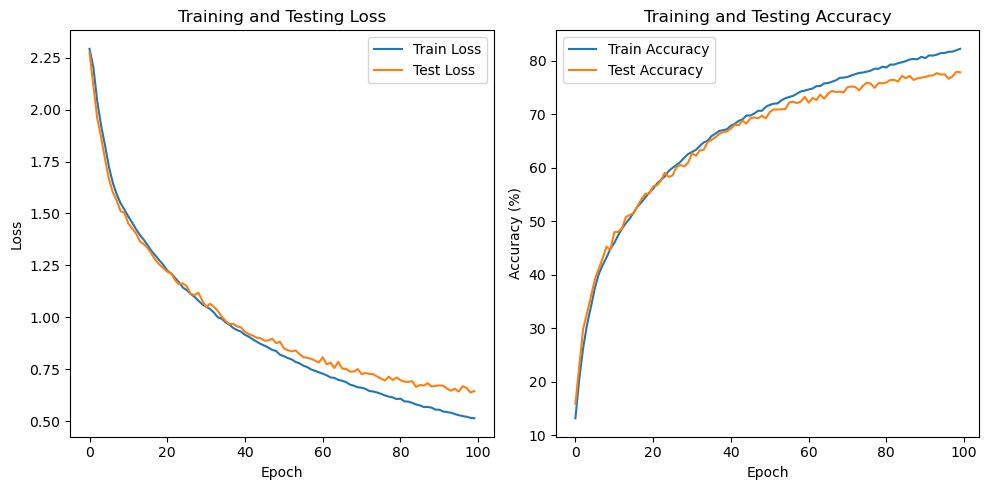

In [21]:

# 学習曲線のプロット (変更なし)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



(10000, 512) (10000,)


/tmp/ipykernel_21015/3110922965.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', len(classes))
/tmp/ipykernel_21015/3110922965.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(principal_components[indices, 0], principal_components[indices, 1],


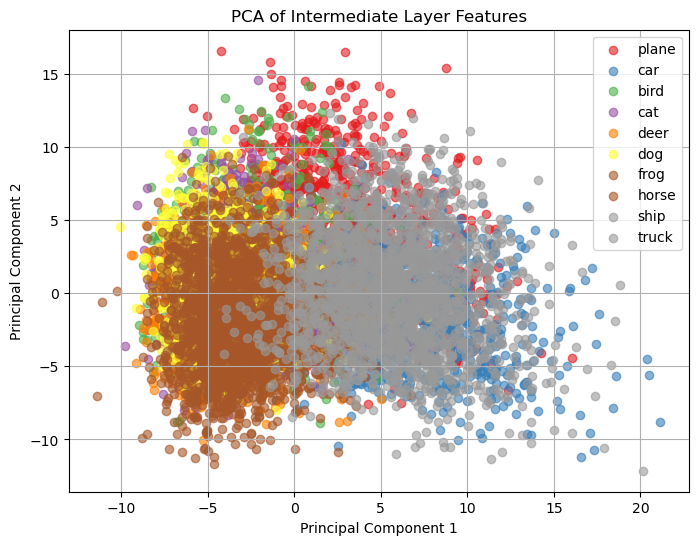

In [22]:
# 中間層の特徴ベクトルの可視化 (変更なし)
net.eval()
all_features = []
all_labels = []
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
#        if i >= 10:  # 最初の10バッチのみ使用 (計算量を抑えるため)
#            break
        images = images.to(device)
        features = net.get_features(images).cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print(all_features.shape, all_labels.shape)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_features)

plt.figure(figsize=(8, 6))
# colors = plt.cm.get_cmap('viridis', len(classes))
# より区別しやすいカラーマップに変更
#colors = plt.cm.get_cmap('tab10', len(classes)) 
colors = plt.cm.get_cmap('Set1', len(classes)) 
for i in range(len(classes)):
    indices = np.where(all_labels == i)[0]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1],
                label=classes[i], alpha=0.6, c=colors(i))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Intermediate Layer Features')
plt.legend()
plt.grid(True)
plt.show()


Visualizing attention for sample with label: horse


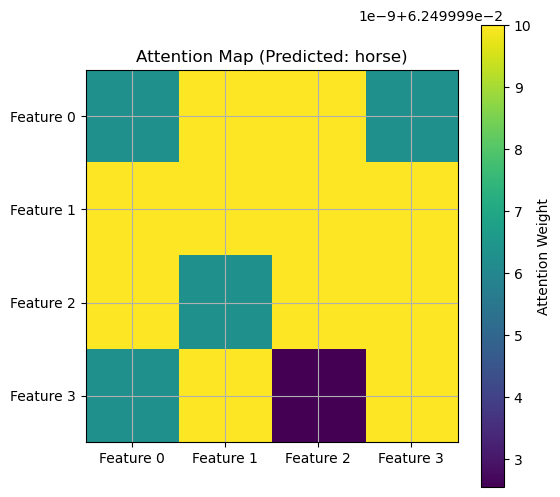

Visualizing attention for sample with label: truck


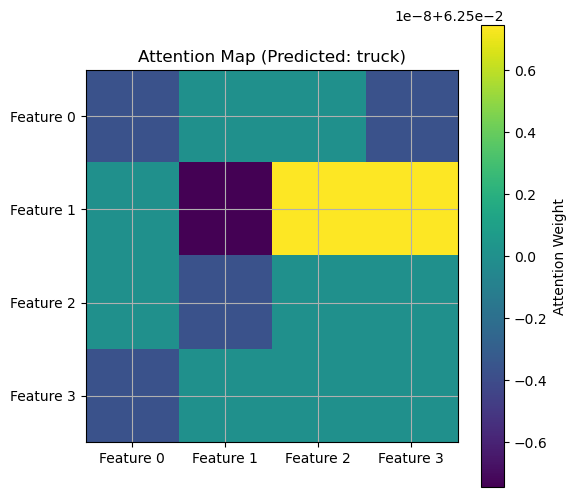

Visualizing attention for sample with label: dog


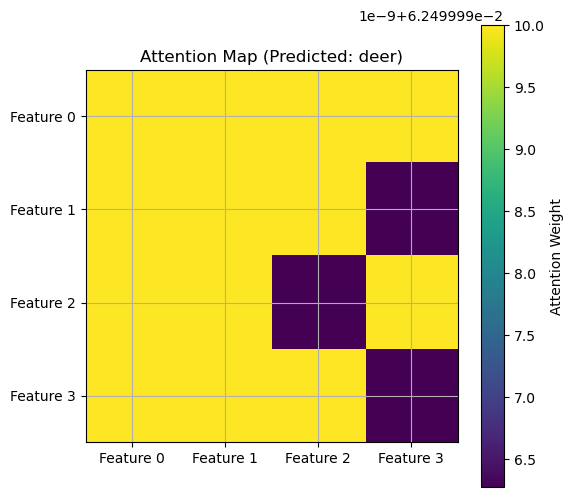

Visualizing attention for sample with label: dog


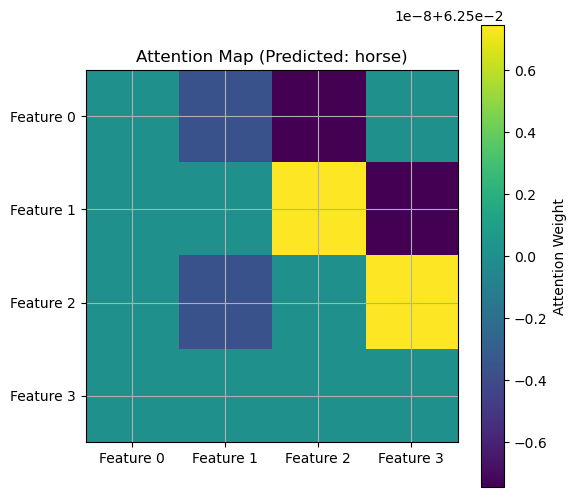

Visualizing attention for sample with label: cat


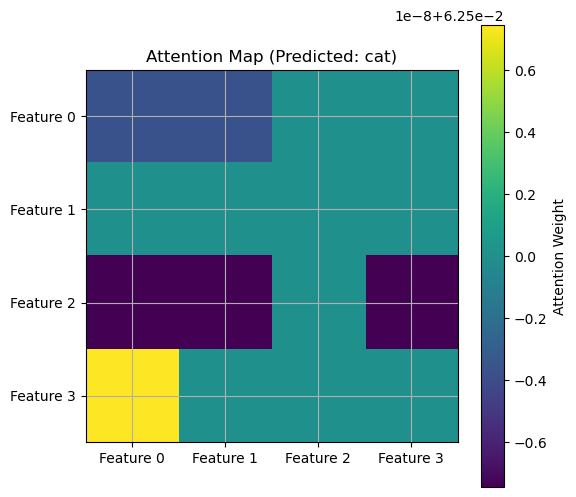

In [23]:

# 学習後のアテンションの可視化
def visualize_attention(model, image, class_names):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # バッチ次元を追加し、デバイスへ
        output, attention_map = model(image)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_names[predicted_idx.item()]

        attention_map = attention_map.squeeze(0).cpu().numpy() # バッチ次元とチャネル次元を削除
        # attention_mapのサイズは (H*W) x (H*W)
        # H, W はプーリング後の特徴マップのサイズ (4x4)
        # attention_map を 4x4 のグリッドとして可視化するためにreshape
        attn_map = attention_map.reshape(4, 4, 4, 4).mean(axis=(2, 3)) # 各4x4のブロックの平均を取る

        plt.figure(figsize=(6, 6))
        plt.imshow(attn_map, cmap='viridis')
        plt.title(f'Attention Map (Predicted: {predicted_class})')
        plt.colorbar(label='Attention Weight')
        plt.xticks(np.arange(4), [f'Feature {i}' for i in range(4)])
        plt.yticks(np.arange(4), [f'Feature {j}' for j in range(4)])
        plt.grid(True)
        plt.show()

# テストデータからランダムなサンプルを選択
num_samples_to_visualize = 5
indices = random.sample(range(len(testset)), num_samples_to_visualize)
for index in indices:
    img, label = testset[index]
    class_name = classes[label]
    print(f"Visualizing attention for sample with label: {class_name}")
    visualize_attention(net, img, classes)